# AGN Scattering Sim Results

First, lets import some packages, deinfe some plotting functions and constants and load the file up

In [4]:
from __future__ import print_function
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.lines as mlines
from typing import List, Optional
import seaborn as sns
from ipywidgets import interactive, IntSlider, Layout
import ipywidgets as widgets
import warnings
import corner
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

rcParams["font.size"] = 20
rcParams["font.family"] = "serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans"]
rcParams["text.usetex"] = True
rcParams['axes.labelsize'] = 30
rcParams['axes.titlesize'] = 30
rcParams['axes.labelpad'] = 20
rcParams["font.size"] = 30
rcParams["font.family"] = "serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans"]
rcParams["text.usetex"] = True
rcParams['axes.labelsize'] = 30
rcParams['axes.titlesize'] = 30
rcParams['axes.labelpad'] = 10
rcParams['axes.linewidth'] = 2.5
rcParams['axes.edgecolor'] = 'black'
rcParams['xtick.labelsize'] = 25
rcParams['xtick.major.size'] = 10.0
rcParams['xtick.minor.size'] = 5.0
rcParams['ytick.labelsize'] = 25
rcParams['ytick.major.size'] = 10.0
rcParams['ytick.minor.size'] = 5.0
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True


def get_colors(num_colors: int, alpha: Optional[float]=1, palette_num=1) -> List[List[float]]:
    """Get a list of colorblind colors,
    :param num_colors: Number of colors.
    :param alpha: The transparency
    :return: List of colors. Each color is a list of [r, g, b, alpha].
    """
    palettes = ['colorblind', "ch:start=.2,rot=-.3"]
    cs = sns.color_palette(palettes[palette_num], n_colors=num_colors)
    cs = [list(c) for c in cs]
    for i in range(len(cs)):
        cs[i].append(alpha)
    return cs



CORNER_KWARGS = dict(
    smooth=0.99,
    label_kwargs=dict(fontsize=30),
    title_kwargs=dict(fontsize=16),
    truth_color='tab:orange',
#     quantiles=[0.16, 0.84],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=False,
    plot_datapoints=False,
    fill_contours=True,
    max_n_ticks=3,
    verbose=False,
    use_math_text=True,
    )

def overlaid_corner(samples_list, sample_labels, axis_labels, plot_range, colors):
    """Plots multiple corners on top of each other"""
    # get some constants
    n = len(samples_list)
    _, ndim = samples_list[0].shape
    min_len = min([len(s) for s in samples_list])

    CORNER_KWARGS.update(range=plot_range, labels=axis_labels)

    fig = corner.corner(
        samples_list[0],
        color=colors[0],
        **CORNER_KWARGS,
    )

    for idx in range(1, n):
        fig = corner.corner(
            samples_list[idx],
            fig=fig,
            weights=get_normalisation_weight(len(samples_list[idx]), min_len),
            color=colors[idx],
            **CORNER_KWARGS
        )

    plt.legend(
        handles=[
            mlines.Line2D([], [], color=colors[i], label=sample_labels[i])
            for i in range(n)
        ],
        fontsize=20, frameon=False,
        bbox_to_anchor=(1, ndim), loc="upper right"
    )
    return fig

def get_normalisation_weight(len_current_samples, len_of_longest_samples):
    return np.ones(len_current_samples) * (len_of_longest_samples / len_current_samples)

In [5]:
SEC_YEAR = 60*60*24*365 # seconds in a year
AVG_SCATTER_TIME = (10 ** 5)* SEC_YEAR # average time for a scattering 

open_data_filename = 'RVA_0_003_01_03_1_2_3_4_5_10_15_25_45_75_90_ISO'
npz_file = np.load(open_data_filename + 'savetestarr' + '.npz')
data_all_array = npz_file['arr_0']
print(f"Number of sim files: {len(npz_file.files)}")


Number of sim files: 1


## Descriptions of attributes
- dc: 
    - This can take values from 0, 15 (1,2,3,4...) 
    - Each value corresponds to an initial inclination between the binary and the incoming single BH. 
    - The value in degree can be seen in the data file name: the first is 0 (co-planar), then 0.003 degrees, where the last is "ISO = isotropic"
    - Therefore, chose dc = 0 for co-planar interactions, etc.

- id_arr: 
    - id = 5 if the BHs merge during the interaction. 
    - id = 3 if BHs merge After the interaction  
    - id >= 10 if the interaction did not end

- obij_arr:
    Tells you which of the two objects that end up in a binary:
    -   1, 2 are the intial binary components
    -   3 is incoming BH
    The encoding shows which pair remains:
    - 1: (1,2) remain
    - 2: (1,3) remain
    - 3: (2,3) remain

- tGWij_SI_arr: inspiral time of resultant binary i,j in seconds.

- fGWij_SI_arr: GW peak frequency of the BBH that merges (i,j)

- ecc_A_arr: lisa eccentricity (dont use)
- ecc_B_arr: eccentricity at 10 Hz. If fGWij_SI_arr > 10 Hz then = -1.


- Lij_ang_arr: Angle between initial and final orbital angular momentum vector.

Note that Lij_ang_arr == the zenith angle of the component BBHs  

![](../diagrams/binary_scattering_agn.png)


Each dataset idx corresponds to an interaction angle:
dc 0: 0.0 deg
dc 1: 0.003 deg
dc 2: 0.01 deg
dc 3: 0.03 deg
dc 4: 1 deg
dc 5: 2 deg
dc 6: 3 deg
dc 7: 4 deg
dc 8: 5 deg
dc 9: 10 deg
dc 10: 15 deg
dc 11: 25 deg
dc 12: 45 deg
dc 13: 75 deg
dc 14: 90 deg
dc 15: ISO deg


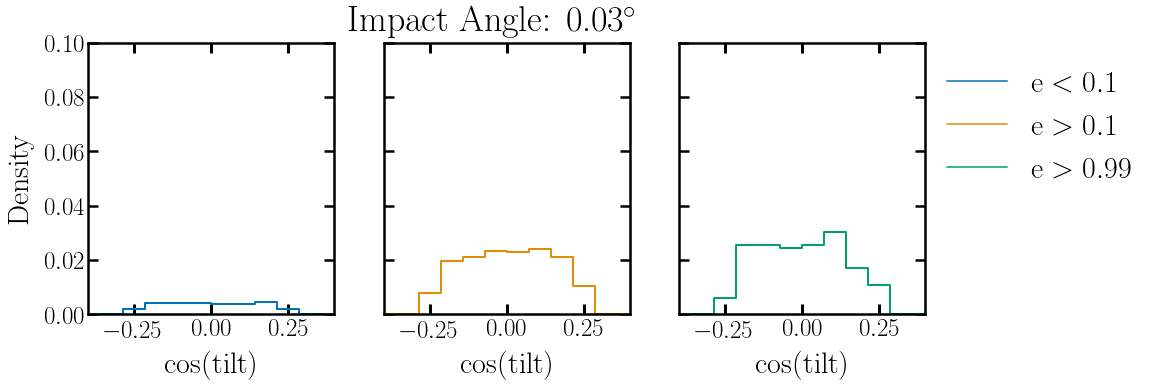

In [72]:



class ScatteringFile:
    def __init__(self, fname):
        self.fname = fname
        npz_file = np.load(self.fname + 'savetestarr' + '.npz')
        self._data = npz_file['arr_0']
        self.angle_info = self.get_angle_info()

    def get_data(self, dc=0):
        return ScatteringData.from_scattering_file_data(
            self._data,
            dc, 
            self.angle_info[dc]
        )

    def get_angle_info(self):
        """The file name encodes some information on the interaction angle"""
        nums_in_str = self.fname.split("_")[1:]
        binary_single_interaction_angle = {}
        for i in range(len(nums_in_str)):
            angle = nums_in_str[i]
            if angle[0]=='0':
                angle = str(float("0."+angle))
            binary_single_interaction_angle.update({i:angle})
        return binary_single_interaction_angle
    
    
    def plot_1d(self, histval, dc_vals=[0,1,2,3,4]):
        fig = plt.figure(figsize=(8.0, 8.0))
        ax1 = fig.add_subplot(111)
        kwargs = dict(histtype='step', density=True, linewidth=3)
        dc_colors = get_colors(len(dc_vals))
        for dc, dc_col in zip(dc_vals, dc_colors):
            scat_dat = self.get_data(dc)
            try:
                ax1.hist(
                    scat_dat.all_systems[histval], color=dc_col, 
                    label=f"{scat_dat.scattering_angle}"+"$^{\\circ}$", **kwargs
                )
            except Exception as e:
                pass
        scat_dat = self.get_data(0)
        ax1.set_xlabel(scat_dat._labels[histval])
        ax1.set_ylabel("Density")
        ax1.set_xlim(*scat_dat._ranges[histval])
        plt.title(f"{scat_dat._labels[histval]} for different Impact Angles")
        plt.legend(frameon=False, markerscale=3, loc="upper right", bbox_to_anchor=(1.85, 1))
        
    
class ScatteringData:
    def __init__(self, inspiral_time, gw_peak_freq, interaction_status, binary_id, ecc, tilt, scattering_angle):
        """
        interaction_status: if merger occured before/during/after (or never) the interaction
        binary_id: which binary pair merges
        inspiral_time: inspiral time (merger time) of binary
        gw_peak_freq: GW peak frequency of the merger
        ligo_ecc: eccentricty at 10Hz (LIGO band)
        tilt: tilt angle of BBHs 
        merger_occured: True if merger occurs
        burst_source: True if burst source (if ecc very large at 10Hz)
        interation_angle: angle of scattering interaction
        """
        self.gw_peak_freq = gw_peak_freq
        self.inspiral_time = inspiral_time
        self.interaction_status = interaction_status
        self.binary_id = binary_id
        self.ecc = ecc
        self.ecc[self.ecc == -1] = 10
        self.tilt = tilt
        self.scattering_angle = scattering_angle
        
        self.cos_tilt = np.cos(np.deg2rad(self.tilt))
        self.merger_occured = self.inspiral_time < AVG_SCATTER_TIME
        self.log10_ecc = np.log10(self.ecc)
        self.log10_gw_peak_freq = np.log10(self.gw_peak_freq)
        self.burst_source = self.ecc == 10
    
    @classmethod
    def from_scattering_file_data(cls, scat_file_data, dc, scattering_angle):
        return cls(
            inspiral_time = scat_file_data[dc, 0, :, 2],
            gw_peak_freq = scat_file_data[dc, 0, :, 4],
            interaction_status = scat_file_data[dc, 0, :, 0],
            binary_id =  scat_file_data[dc, 0, :, 1],
            ecc= scat_file_data[dc, 0, :, 8],
            tilt = scat_file_data[dc, 0, :, 9],
            scattering_angle = scattering_angle
        )   
    
    @property
    def all_systems(self):
        return pd.DataFrame(dict(
            cos_tilt = self.cos_tilt,
            ecc = self.ecc,
            log10_ecc = self.log10_ecc,
            log10_gw_peak_freq = self.log10_gw_peak_freq,
            burst_source = self.burst_source,
            merger_occured = self.merger_occured
        ))
        
    @property
    def merging_systems(self):
        df = self.all_systems
        return df[(df['merger_occured']==True)&(df['burst_source']==False)]
    
    @property
    def non_merging_systems(self):
        df = self.all_systems
        return df[(df['merger_occured']==False)&(df['burst_source']==False)]
        
    @property
    def burst_systems(self):
        df = self.all_systems
        return df[df['burst_source']==True]
    
    @property
    def _labels(self):
        return dict(
        log10_ecc = "$\\log_{10}\ \\mathrm{e}$",
        log10_gw_peak_freq = "$\\log_{10} f_{\\mathrm{GW}}$",
        cos_tilt = "$\\cos(\\mathrm{tilt})$"
        )
    

    @property
    def _ranges(self):
        return dict(
            log10_ecc = (-9, 0),
            log10_gw_peak_freq = (-6, 0),
            cos_tilt = (-1, 1)
        )
    
    def plot_2d(self, xval, yval):
        fig = plt.figure(figsize=(8.0, 8.0))
        ax1 = fig.add_subplot(111)
        kwargs = dict(marker='.', markersize=5.0, linewidth=0, zorder=-1)
        ax1.plot(self.merging_systems[xval], self.merging_systems[yval], color='gray', label="Merger Occurs", **kwargs)                      
        ax1.plot(self.non_merging_systems[xval], self.non_merging_systems[yval], color='red', label="No Merger", **kwargs)
#         ax1.plot(self.burst_systems[xval], self.burst_systems[yval], color='blue', label="Burst", **kwargs)
        ax1.set_xlabel(self._labels[xval])
        ax1.set_ylabel(self._labels[yval])
        ax1.set_xlim(*self._ranges[xval])
        ax1.set_ylim(*self._ranges[yval])
        plt.title(f"Impact Angle: {self.scattering_angle}" + "$^{\\circ}$")
        plt.legend(frameon=False, markerscale=3, loc="upper right", bbox_to_anchor=(1.85, 1))
        
    def plot_1d(self, histval):
        fig = plt.figure(figsize=(8.0, 8.0))
        ax1 = fig.add_subplot(111)
        kwargs = dict(histtype='step', density=True, linewidth=3)
        ax1.hist(self.merging_systems[histval], color='gray', label="Merger Occurs", **kwargs)                      
        ax1.hist(self.non_merging_systems[histval], color='red', label="No Merger", **kwargs)
        ax1.set_xlabel(self._labels[histval])
        ax1.set_ylabel("Density")
        ax1.set_xlim(*self._ranges[histval])
        plt.title(f"Impact Angle: {self.scattering_angle}" + "$^{\\circ}$")
        plt.legend(frameon=False, markerscale=3, loc="upper right", bbox_to_anchor=(1.85, 1))
    
    def plot_tilt_for_diff_ecc(self):
        fig = plt.figure(figsize=(8.0, 8.0))
        ax1 = fig.add_subplot(111)
        kwargs = dict(histtype='step', density=True, linewidth=3)
        e_below_01 = self.all_systems[self.all_systems.ecc < 0.1]
        e_above_01 = self.all_systems[self.all_systems.ecc > 0.1]
        e_above_099 = self.all_systems[self.all_systems.ecc > 0.99]
        e_dat = [e.cos_tilt for e in [e_below_01, e_above_01, e_above_099]]
        colors = get_colors(3, palette_num=0)
        labels = ["$\\mathrm{e} < 0.1$", "$\\mathrm{e}>0.1$", "$\\mathrm{e}>0.99$"]
        for i in range(len(e_dat)):
            ax1.hist(e_dat[i], color=colors[i], label=labels[i], **kwargs)                      
        ax1.set_xlabel(self._labels["cos_tilt"])
        ax1.set_ylabel("Density")
        ax1.set_xlim(*self._ranges["cos_tilt"])
        ax1.set_ylim(0,3.5)
        plt.title(f"Impact Angle: {self.scattering_angle}" + "$^{\\circ}$")
        plt.legend(frameon=False, markerscale=3, loc="upper right", bbox_to_anchor=(1.85, 1))
        plt.show()
        
    def plot_corner(self, dc_idx=1):
        p = ['log10_gw_peak_freq','log10_ecc', 'cos_tilt']
        fig = overlaid_corner(
            samples_list=[self.merging_systems[p], self.non_merging_systems[p]],
            sample_labels=["Merger Occurs", "No Merger"],
            axis_labels=[self._labels[param] for param in p],
            plot_range=[self._ranges[param] for param in p],
            colors=['gray', 'red']
        )
        fig.suptitle(f"Impact Angle: {self.scattering_angle}" + "$^{\\circ}$", y=1.05)
        
    def plot_probability_of_in_plane_merger(self):
        fig = plt.figure(figsize=(8.0, 8.0))
        ax1 = fig.add_subplot(111)
        kwargs = dict(histtype='step', density=True, linewidth=3)
        e_below_01 = self.all_systems[self.all_systems.ecc < 0.1]
        e_above_01 = self.all_systems[self.all_systems.ecc > 0.1]
        e_above_099 = self.all_systems[self.all_systems.ecc > 0.99]
        total_lens = [len(e) for e in [e_below_01, e_above_01, e_above_099]]
        e_below_01 = e_below_01[(e_below_01.cos_tilt > -0.25)&(e_below_01.cos_tilt < 0.25)]
        e_above_01 = e_above_01[(e_above_01.cos_tilt > -0.25)&(e_above_01.cos_tilt < 0.25)]
        e_above_099 = e_above_099[(e_above_099.cos_tilt > -0.25)&(e_above_099.cos_tilt < 0.25)]
        e_dat = [e.cos_tilt for e in [e_below_01, e_above_01, e_above_099]]
        e_dat = [dat/l for dat,l in zip(e_dat, total_lens)]
        colors = get_colors(3, palette_num=0)
        labels = ["$\\mathrm{e} < 0.1$", "$\\mathrm{e}>0.1$", "$\\mathrm{e}>0.99$"]
        for i in range(len(e_dat)):
            ax1.hist(e_dat[i], color=colors[i], label=labels[i], **kwargs)                      
        ax1.set_xlabel(self._labels["cos_tilt"])
        ax1.set_ylabel("Density")
        ax1.set_xlim(*self._ranges["cos_tilt"])
        ax1.set_ylim(0,3.5)
        plt.title(f"Impact Angle: {self.scattering_angle}" + "$^{\\circ}$")
        plt.legend(frameon=False, markerscale=3, loc="upper right", bbox_to_anchor=(1.85, 1))
        plt.show()

        
    def plot_only_prob_in_plane(self):
        fig, axs = plt.subplots(1, 3, sharex=True,sharey=True, figsize=(15.0, 5.0))
        kwargs = dict( linewidth=2, where='post')
        bins = np.linspace(-0.5, 0.5, num=15)
        e_below_01 = self.all_systems[self.all_systems.ecc < 0.1]
        e_above_01 = self.all_systems[self.all_systems.ecc > 0.1]
        e_above_099 = self.all_systems[self.all_systems.ecc > 0.99]
        total_lens = [len(e) for e in [e_below_01, e_above_01, e_above_099]]
        e_below_01 = e_below_01[(e_below_01.cos_tilt > -0.25)&(e_below_01.cos_tilt < 0.25)]
        e_above_01 = e_above_01[(e_above_01.cos_tilt > -0.25)&(e_above_01.cos_tilt < 0.25)]
        e_above_099 = e_above_099[(e_above_099.cos_tilt > -0.25)&(e_above_099.cos_tilt < 0.25)]
        e_dat = [e.cos_tilt for e in [e_below_01, e_above_01, e_above_099]]
        e_dat = [dat for dat,l in zip(e_dat, total_lens)]
        colors = get_colors(3, palette_num=0)
        labels = ["$\\mathrm{e} < 0.1$", "$\\mathrm{e}>0.1$", "$\\mathrm{e}>0.99$"]
        for i in range(3):
            counts, bin_edges = np.histogram(e_dat[i], bins)                      
            counts = counts/total_lens[i]
            axs[i].step(bin_edges[:-1], counts, color=colors[i],  label=labels[i], **kwargs)
            axs[i].set_xlim(-0.4, 0.4)
            axs[i].set_ylim(0, 0.1)
            axs[i].set_xlabel(self._labels["cos_tilt"])
        axs[0].set_ylabel("Density")

        plt.suptitle(f"Impact Angle: {self.scattering_angle}" + "$^{\\circ}$")
        axs[2].legend(
            handles=[
                mlines.Line2D([], [], color=colors[i], label=labels[i])
                for i in range(3)
            ],frameon=False,
            bbox_to_anchor=(1.95, 1), loc="upper right"
        )
        plt.show()
        
scat_file = ScatteringFile(open_data_filename)
print("Each dataset idx corresponds to an interaction angle:")
for dc, angle in scat_file.angle_info.items():
    print(f"dc {dc}: {angle} deg")
    
scat_file.get_data(3).plot_only_prob_in_plane()

In [73]:
Ω

NameError: name 'Ω' is not defined

# Plots 

In [74]:
COLS = ['log10_gw_peak_freq',  'log10_ecc', 'cos_tilt']

def plot_2d_data(dc_idx=1, xval='log10_gw_peak_freq', yval='cos_tilt'):
    scat_file = ScatteringFile(open_data_filename)
    dc_dat = scat_file.get_data(dc=dc_idx)       
    dc_dat.plot_2d(xval, yval)
    plt.show()
    
def plot_1d_data(dc_idx=1, histval='cos_tilt'):
    scat_file = ScatteringFile(open_data_filename)
    dc_dat = scat_file.get_data(dc=dc_idx)       
    dc_dat.plot_1d(histval)
    plt.show()
    
    
def plot_different_scat_hist(histval='cos_tilt'):
    scat_file.plot_1d(histval, dc_vals=[0, 2, 4, 6, 8, 10, 12, 14])
    plt.show()

def plot_scat_corner(dc_idx=1):
    scat_file = ScatteringFile(open_data_filename)
    dc_dat = scat_file.get_data(dc=dc_idx)       
    dc_dat.plot_corner()
    plt.show()
    
def plot_ecc(dc_idx):
    scat_file = ScatteringFile(open_data_filename)
    dc_dat = scat_file.get_data(dc=dc_idx)       
#     dc_dat.plot_tilt_for_diff_ecc()
    dc_dat.plot_probability_of_in_plane_merger()
    plt.show()
    
def plot_prob_in_plane(dc_idx):
    scat_file = ScatteringFile(open_data_filename)
    dc_dat = scat_file.get_data(dc=dc_idx)       
#     dc_dat.plot_tilt_for_diff_ecc()
    dc_dat.plot_only_prob_in_plane()
    plt.show()
    
def make_interactive_plot(plotting_func, my_kwargs={}):
    interactive_ploter = interactive(
        plotting_func,
        dc_idx=IntSlider(value=1, min=1, max=15, setp=1, continuous_update=False),
        save=True,
        **my_kwargs
    )
    output_interactive_ploter = interactive_ploter.children[-1]
    output_interactive_ploter.layout.height = '600px'
    return interactive_ploter


interactive_1d_plot = make_interactive_plot(plot_1d_data, my_kwargs=dict(histval=COLS))
interactive_2d_plot = make_interactive_plot(plot_2d_data, my_kwargs=dict(xval=COLS, yvals=COLS))
interactive_corner_plot = make_interactive_plot(plot_scat_corner)
interactive_scatter_angles_plot = make_interactive_plot(plot_different_scat_hist, my_kwargs=dict(histval=COLS))
interactive_ecc_tilt = make_interactive_plot(plot_ecc)
interactive_p_in_plane = make_interactive_plot(plot_prob_in_plane)


In [75]:
interactive_p_in_plane

interactive(children=(IntSlider(value=1, continuous_update=False, description='dc_idx', max=15, min=1), Output…

In [103]:
interactive_ecc_tilt

interactive(children=(IntSlider(value=1, continuous_update=False, description='dc_idx', max=15, min=1), Output…

In [95]:
interactive_1d_plot

interactive(children=(IntSlider(value=1, continuous_update=False, description='dc_idx', max=15, min=1), Dropdo…

In [96]:
interactive_2d_plot

interactive(children=(IntSlider(value=1, continuous_update=False, description='dc_idx', max=15, min=1), Dropdo…

In [97]:
interactive_corner_plot

interactive(children=(IntSlider(value=1, continuous_update=False, description='dc_idx', max=15, min=1), Output…

In [98]:
interactive_scatter_angles_plot

interactive(children=(Dropdown(description='histval', index=2, options=('log10_gw_peak_freq', 'log10_ecc', 'co…

In [100]:
# Kick calculations

# Kick calculations

Since $L_{ij}==\text{BH}_i,\text{BH}_j\text{ zenith angle}$, we can calculate $\chi_1$, $\chi_2$:
\begin{align*}
\chi_{ij}[x] &= r \sin(L_{ij}) \cos(\phi) \\
\chi_{ij}[y] &= r \sin(L_{ij}) \sin(\phi) \\
\chi_{ij}[z] &= r \cos(L_{ij})\ .
\end{align*}

We take $r=0.5$ and $\phi=0$. Note, right now $r$ and $\phi$ are the same for each binary pair... We might need to change this in the future.



In [100]:
CALC_KICK = False

if CALC_KICK:
    from bbh_simulator.calculate_kick_vel_from_samples import Samples
    
    r = 0.5
    phi = 0
    mass = 20


    def calculate_kick_samples(dc_idx=1, num_samples=1000):
        dc_dat = scat_data.get_data(dc=dc_idx)
        if num_samples > len(dc_dat):
            raise ValueError("Asking for too many samples! ")
        Lij = np.radians(dc_dat['Lij_ang_arr'])
        dc_dat['mass_1_source'] = mass
        dc_dat['spin_1x'] = r * np.sin(Lij) * np.cos(phi) 
        dc_dat['spin_1y'] = r * np.sin(Lij) * np.sin(phi) 
        dc_dat['spin_1z'] = r * np.cos(Lij) 
        dc_dat['mass_2_source'] = dc_dat['mass_1_source'] 
        dc_dat['spin_2x'] = dc_dat['spin_1x'] 
        dc_dat['spin_2y'] = dc_dat['spin_1y'] 
        dc_dat['spin_2z'] = dc_dat['spin_1z'] 
        s = Samples(posterior=dc_dat.sample(num_samples))
        s.calculate_remnant_kick_velocity()
        s.posterior.to_csv(f'dc{dc_idx}_samples_with_kicks.csv')
        return s.posterior


    samples = calculate_kick_samples(dc_idx=1, num_samples=10000)